# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [ ]:
from google.colab import files
files.upload()

Saving df_final.csv to df_final.csv


{'df_final.csv': b'TransactionAmount,TransactionType,Channel,LoginAttempts,AccountBalance,CustomerOccupation,Cluster_DBSCAN\n14.089999999999975,Debit,ATM,1.0,5112.21,Doctor,0\n376.24,Debit,ATM,1.0,13758.91,Doctor,0\n126.28999999999999,Debit,Online,1.0,1122.35,Student,0\n184.5,Debit,Online,1.0,8569.06,Student,0\n13.449999999999989,Credit,Online,1.0,7429.4,Student,0\n92.15,Debit,ATM,1.0,781.6800000000003,Student,0\n7.079999999999984,Credit,ATM,1.0,13316.71,Doctor,0\n171.42,Credit,Branch,1.0,2796.24,Retired,0\n106.23000000000002,Credit,Branch,1.0,9095.14,Engineer,0\n815.96,Debit,ATM,1.0,1021.8799999999997,Doctor,0\n17.78000000000003,Credit,Online,1.0,7599.52,Engineer,0\n190.02000000000004,Debit,Online,1.0,1528.81,Student,0\n494.52,Credit,Branch,1.0,1620.02,Student,0\n781.76,Debit,ATM,1.0,189.6899999999996,Student,0\n166.99,Debit,Online,1.0,299.9300000000003,Student,0\n465.45,Debit,ATM,1.0,3465.54,Engineer,0\n555.8,Credit,Branch,1.0,1131.2600000000002,Student,0\n492.93,Debit,Online,1.0,510

In [ ]:
df = pd.read_csv('df_final.csv')

In [ ]:
df

,TransactionAmount,TransactionType,Channel,LoginAttempts,AccountBalance,CustomerOccupation,Cluster_DBSCAN
0,14.09,Debit,ATM,1.0,5112.21,Doctor,0
1,376.24,Debit,ATM,1.0,13758.91,Doctor,0
2,126.29,Debit,Online,1.0,1122.35,Student,0
3,184.50,Debit,Online,1.0,8569.06,Student,0
4,13.45,Credit,Online,1.0,7429.40,Student,0
...,...,...,...,...,...,...,...
2507,856.21,Credit,Branch,1.0,12690.79,Doctor,0
2508,251.54,Debit,Branch,1.0,254.75,Doctor,0
2509,28.63,Debit,Branch,1.0,3382.91,Retired,0
2510,185.97,Debit,Online,1.0,1776.91,Student,0


In [ ]:
df.Cluster_DBSCAN.value_counts()

,count
Cluster_DBSCAN,
0,2370
-1,133
1,9


In [ ]:
df['IsFraud'] = df['Cluster_DBSCAN'].apply(lambda x: 1 if x in [-1, 1] else 0)
df =df.drop(columns=['Cluster_DBSCAN'])
# Cek jumlah label hasil klasifikasi
print(df['IsFraud'].value_counts())


IsFraud
0    2370
1     142
Name: count, dtype: int64


Disini, saya menggabungkan label -1 dan 1 karena ketimpangan yang terlalu besar untuk Cluster dengan label 1 (9 data saja). Dikarenakan Label -1 dan label 1 sama-sama potensi fraud (yang membedakan cuman label -1 adalah anomali dan label 1 adalah potensi fraud yang perlu di pantau. Sehingga menggabungkan mereka menjadi "potensi fraud" akan lebih memudahkan model nantinya.

In [ ]:
df

,TransactionAmount,TransactionType,Channel,LoginAttempts,AccountBalance,CustomerOccupation,IsFraud
0,14.09,Debit,ATM,1.0,5112.21,Doctor,0
1,376.24,Debit,ATM,1.0,13758.91,Doctor,0
2,126.29,Debit,Online,1.0,1122.35,Student,0
3,184.50,Debit,Online,1.0,8569.06,Student,0
4,13.45,Credit,Online,1.0,7429.40,Student,0
...,...,...,...,...,...,...,...
2507,856.21,Credit,Branch,1.0,12690.79,Doctor,0
2508,251.54,Debit,Branch,1.0,254.75,Doctor,0
2509,28.63,Debit,Branch,1.0,3382.91,Retired,0
2510,185.97,Debit,Online,1.0,1776.91,Student,0


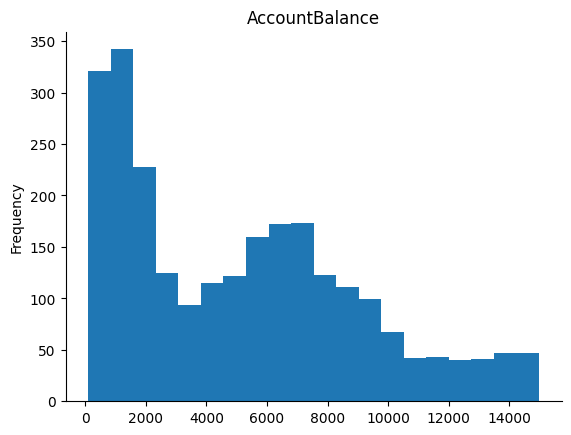

In [ ]:
df['AccountBalance'].plot(kind='hist', bins=20, title='AccountBalance')
plt.gca().spines[['top', 'right',]].set_visible(False)

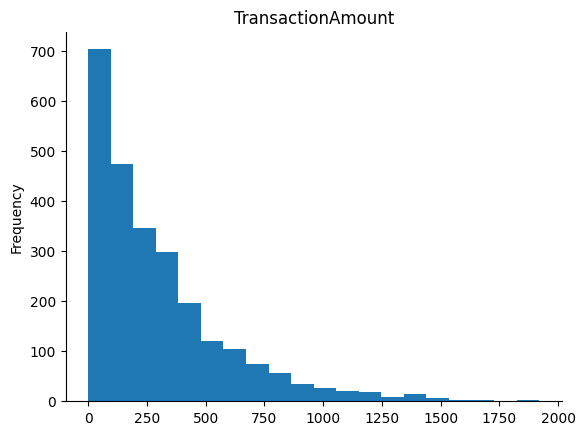

In [ ]:
df['TransactionAmount'].plot(kind='hist', bins=20, title='TransactionAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

Terlihat datanya sangat miring ke arah tertentu, yang didominasi oleh transaction berjumlah sedikit.

In [ ]:
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']


In [ ]:
# Kolom numerik dan kategorikal
num_features = ['TransactionAmount', 'LoginAttempts', 'AccountBalance']
cat_features = ['TransactionType', 'Channel', 'CustomerOccupation']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [ ]:
# Split data stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [ ]:
# Oversampling sedikit agar seimbang
smote = SMOTE(random_state=42, sampling_strategy=0.25)

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

## **b. Evaluasi Model Klasifikasi**


=== Random Forest ===
[[711   0]
 [  4  39]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       711
           1       1.00      0.91      0.95        43

    accuracy                           0.99       754
   macro avg       1.00      0.95      0.97       754
weighted avg       0.99      0.99      0.99       754



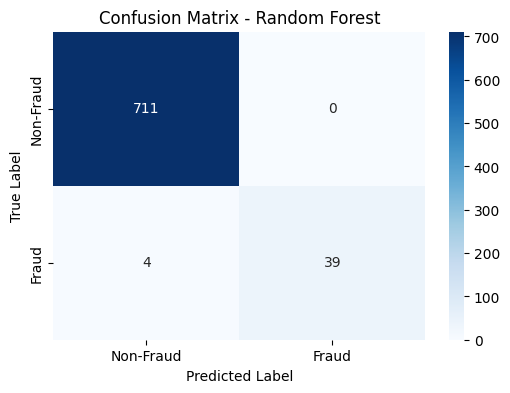

Cross-Validation F1 Scores: [0.92857143 0.96428571 1.         0.94545455 0.96296296]
Mean F1 Score: 0.9602549302549303

=== XGBoost ===
[[709   2]
 [  1  42]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.95      0.98      0.97        43

    accuracy                           1.00       754
   macro avg       0.98      0.99      0.98       754
weighted avg       1.00      1.00      1.00       754



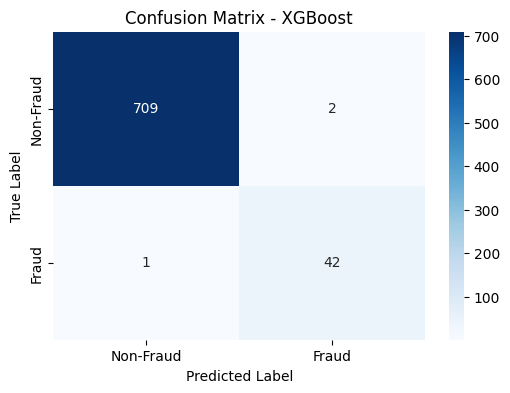

Cross-Validation F1 Scores: [0.96428571 0.98245614 0.94915254 0.94545455 1.        ]
Mean F1 Score: 0.9682697884928035

=== SVM ===
[[710   1]
 [  1  42]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.98      0.98      0.98        43

    accuracy                           1.00       754
   macro avg       0.99      0.99      0.99       754
weighted avg       1.00      1.00      1.00       754



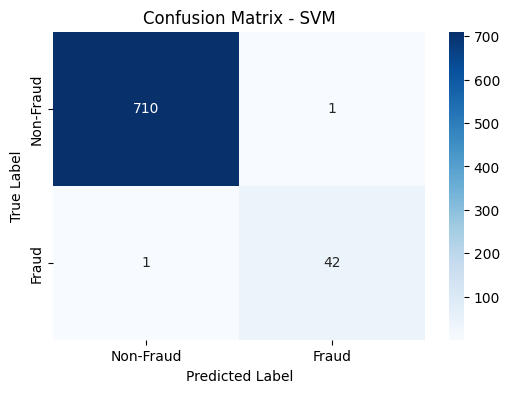

Cross-Validation F1 Scores: [0.96551724 0.98245614 0.96551724 0.90909091 0.98245614]
Mean F1 Score: 0.9610075345102569


In [ ]:
for name, model in models.items():
    print(f"\n=== {name} ===")
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Cross-Validation F1 Score
    scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
    print("Cross-Validation F1 Scores:", scores)
    print("Mean F1 Score:", scores.mean())


Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [ ]:
# Define untuned baseline models with default settings
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

param_grids = {
    "Random Forest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    },
    "XGBoost": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__gamma': [0, 0.1, 0.2]
    },
    "SVM": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3, 4]
    }
}

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


=== Random Forest ===
[[711   0]
 [  4  39]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       711
           1       1.00      0.91      0.95        43

    accuracy                           0.99       754
   macro avg       1.00      0.95      0.97       754
weighted avg       0.99      0.99      0.99       754



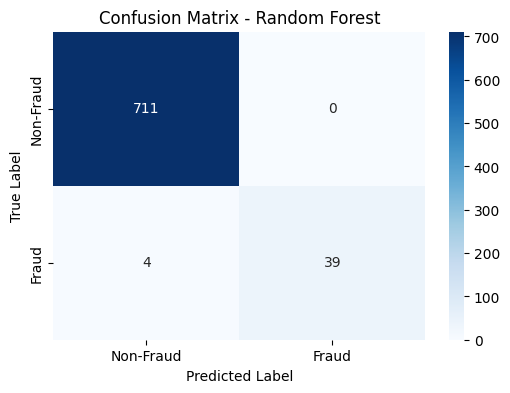

Cross-Validation F1 Scores: [0.92857143 0.96428571 1.         0.94545455 0.96296296]
Mean F1 Score: 0.9602549302549303
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

=== XGBoost ===
[[709   2]
 [  2  41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.95      0.95      0.95        43

    accuracy                           0.99       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.99      0.99      0.99       754



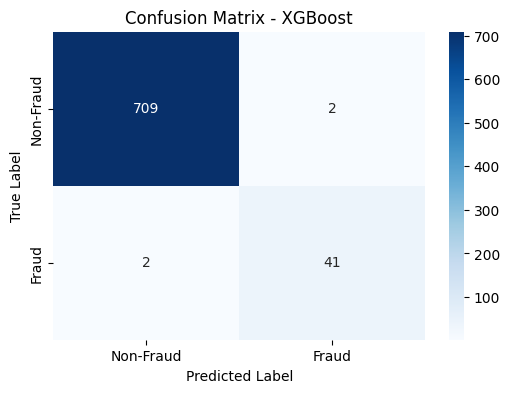

Cross-Validation F1 Scores: [0.98245614 0.98245614 0.96551724 0.94545455 1.        ]
Mean F1 Score: 0.975176813507122
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}

=== SVM ===
[[710   1]
 [  1  42]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.98      0.98      0.98        43

    accuracy                           1.00       754
   macro avg       0.99      0.99      0.99       754
weighted avg       1.00      1.00      1.00       754



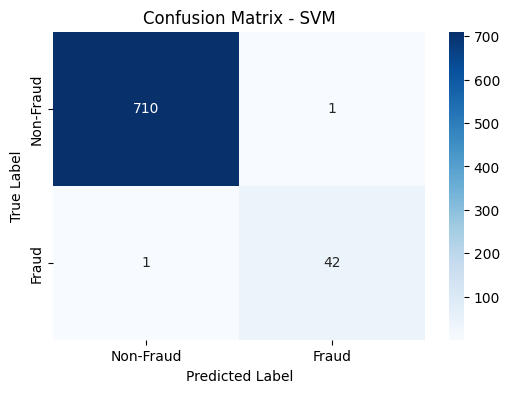

Cross-Validation F1 Scores: [0.96551724 0.98245614 0.98245614 0.90909091 0.98245614]
Mean F1 Score: 0.9643953143045703
Best Parameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


In [ ]:
for name, model in models.items():
    print(f"\n=== {name} ===")
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])

    if name == "XGBoost":
        search = RandomizedSearchCV(clf, param_grids[name], n_iter=5, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    else:
        search = GridSearchCV(clf, param_grids[name], cv=3, scoring='f1', n_jobs=-1)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Cross-Validation F1 Score
    scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
    print("Cross-Validation F1 Scores:", scores)
    print("Mean F1 Score:", scores.mean())
    print("Best Parameters:", search.best_params_)


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

# Evaluasi Model Machine Learning

## **1. Random Forest**

### Sebelum Tuning
- **Accuracy**: 99%
- **Precision (Kelas 1 - Minoritas)**: 1.00
- **Recall (Kelas 1 - Minoritas)**: 0.91 → Ada sedikit kekurangan dalam menangkap kelas minoritas
- **Mean F1 Score (CV)**: 0.9603
- **Overfitting**: Tidak terlihat jelas, namun recall sedikit lebih rendah dibanding model lain.

### Sesudah Tuning
- **Accuracy**: 99%
- **Precision (Kelas 1 - Minoritas)**: 1.00
- **Recall (Kelas 1 - Minoritas)**: 0.91 → Tidak ada perubahan dari sebelumnya
- **Mean F1 Score (CV)**: 0.9603 (Tidak berubah)

## **2. XGBoost**

### Sebelum Tuning
- **Accuracy**: 100%
- **Precision (Kelas 1 - Minoritas)**: 0.95
- **Recall (Kelas 1 - Minoritas)**: 0.98 → Sangat tinggi
- **Mean F1 Score (CV)**: 0.9683

### Sesudah Tuning
- **Accuracy**: 99%
- **Precision (Kelas 1 - Minoritas)**: 0.95
- **Recall (Kelas 1 - Minoritas)**: 0.95 → Sedikit turun dibanding sebelumnya
- **Mean F1 Score (CV)**: 0.9752 (Meningkat dari sebelumnya)


## **3. SVM**

### Sebelum Tuning
- **Accuracy**: 100%
- **Precision (Kelas 1 - Minoritas)**: 0.98
- **Recall (Kelas 1 - Minoritas)**: 0.98 → Kuat dalam menangkap kelas minoritas
- **Mean F1 Score (CV)**: 0.9610

### Sesudah Tuning
- **Accuracy**: 100%
- **Precision (Kelas 1 - Minoritas)**: 0.98
- **Recall (Kelas 1 - Minoritas)**: 0.98 → Tidak berubah
- **Mean F1 Score (CV)**: 0.9644 (Meningkat sedikit)


**Kesimpulan**
1. Untuk Random Forest, model tetap stabil dengan akurasi 99% baik sebelum maupun setelah tuning. Precision buat kelas minoritas masih di angka 1.00, tapi recall-nya tetap di 0.91, yang berarti model masih kurang optimal dalam menangkap kelas minoritas. Rata-rata F1 score dari cross-validation juga tidak berubah, tetap berada di 0.9603. Hasil tuning yang di dapat adalah parameter terbaik kayak bootstrapping yang aktif, kedalaman pohon yang tidak dibatasi, minimum sampel per daun sebesar 2, minimum split sebesar 5, dan jumlah estimators 100. Tapi, tuning ini nggak ngasih dampak signifikan ke performa model.

2. Buat XGBoost, model awalnya dapet akurasi 100% dengan recall 0.98 buat kelas minoritas, yang berarti model ini udah lumayan baik menangkap kelas minoritas. Rata-rata F1 score dari cross-validation juga udah tinggi, yaitu 0.9683. Setelah tuning, akurasi sedikit turun jadi 99%, dan recall buat kelas minoritas juga turun dikit jadi 0.95. Tapi, rata-rata F1 score justru naik ke 0.9752, yang berarti model jadi lebih stabil di berbagai skenario validasi. Parameter terbaik hasil tuningnya termasuk subsample 0.8, jumlah estimators yang lebih kecil (50), kedalaman maksimum pohon 3, learning rate 0.1, dan gamma 0. Ini menunjukkan kalau tuning berhasil bikin model lebih general, meskipun jumlah estimators yang lebih kecil bikin recall agak turun.

3. Sementara buat SVM, performanya sangat stabil. Akurasi tetap di angka 100% sebelum dan sesudah tuning. Precision dan recall buat kelas minoritas juga masih di angka 0.98, nunjukin kalau model ini udah sangat solid buat klasifikasi. Rata-rata F1 score naik dikit setelah tuning, dari 0.9610 ke 0.9644. Parameter terbaiknya hasil tuning adalah C sebesar 1, derajat polinomial 2, gamma auto, dan kernel RBF. Karena model udah optimal dari awal, tuning nggak terlalu ngasih perubahan besar.